In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numpy version :  1.21.5
pandas version :  1.4.2
seaborn version :  0.11.2


In [2]:
train = pd.read_csv('train.csv')

In [3]:
train = train.drop('id', axis=1)
# kita drop kolom 'id'

In [4]:
train=train.drop_duplicates()

In [5]:
Q1 = train['Annual_Premium'].quantile(0.25)
Q3 = train['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
train = train[~((train['Annual_Premium'] < (Q1 - 1.5 * IQR)) |(train['Annual_Premium'] > (Q3 + 1.5 * IQR)))]


In [6]:
train = train.dropna().reset_index(drop=True)
train['Gender'] = train['Gender'].replace("Female", 0).replace("Male", 1)
#merubah nilai data gender female menjadi 0 dan male menjadi 1

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,1,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,1,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,1,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,0,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
train['Vehicle_Age'] = train['Vehicle_Age'].replace(['> 2 Years'], '3')
train['Vehicle_Age'] = train['Vehicle_Age'].replace(['1-2 Year'], '2')
train['Vehicle_Age'] = train['Vehicle_Age'].replace(['< 1 Year'], '1')
# merubah nilai data pada kolom depents dari 3+ menjadi 3

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,3,Yes,40454.0,26.0,217,1
1,1,76,1,3.0,0,2,No,33536.0,26.0,183,0
2,1,47,1,28.0,0,3,Yes,38294.0,26.0,27,1
3,1,21,1,11.0,1,1,No,28619.0,152.0,203,0
4,0,29,1,41.0,1,1,No,27496.0,152.0,39,0


In [8]:
train = train.dropna().reset_index(drop=True)
train['Vehicle_Damage'] = train['Vehicle_Damage'].replace("No", 0).replace("Yes", 1)
train.head()
#merubah nilai data gender female menjadi 0 dan male menjadi 1

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [9]:
convert_dict = {'Vehicle_Age': int
                }
 
train = train.astype(convert_dict)

In [10]:
# import library
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(['Response'],axis = 1)
Y = train ['Response']
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_rus, Y_rus = rus.fit_resample(X, Y)

print(f'''Shape of X before under sampling : {X.shape}
Shape of X after under sampling : {X_rus.shape}''')

print('\nBalance of positive and negative classes (%):')
Y_rus.value_counts(normalize=True) * 100

Shape of X before under sampling : (370509, 10)
Shape of X after under sampling : (90260, 10)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Response, dtype: float64

## XG BOOST

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
X_train, X_test, y_train, y_test = train_test_split(X_rus, Y_rus, test_size=0.25, random_state=42)

from xgboost import XGBClassifier
#Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
classifier = xgboost.XGBClassifier()

params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

#model fitting
rs_model.fit(X_train,y_train)

#parameters selected
rs_model.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

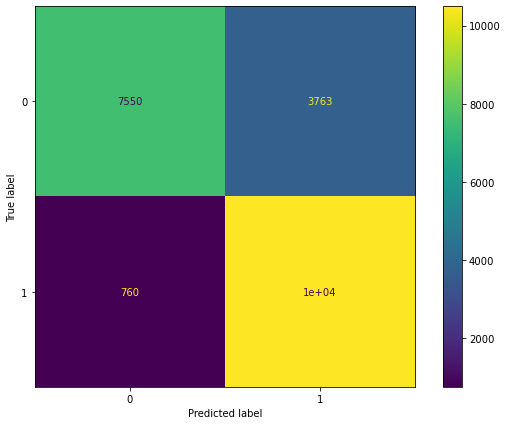

In [14]:
# the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = rs_model.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rs_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rs_model.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [15]:
# classification report
from sklearn.metrics import classification_report
y_pred = rs_model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     11313
           1       0.74      0.93      0.82     11252

    accuracy                           0.80     22565
   macro avg       0.82      0.80      0.80     22565
weighted avg       0.82      0.80      0.80     22565



In [16]:
# no skill
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

#Xgboost
y_probs= rs_model.best_estimator_.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_probs[:,1])

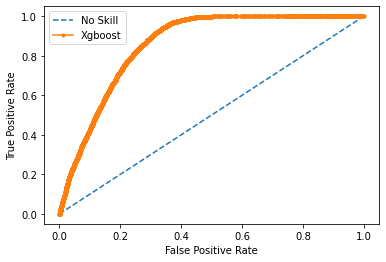

In [17]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Xgboost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

In [18]:
train.head(5)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [19]:

y_pred = rs_model.best_estimator_.predict(X_test)

In [21]:
input_data = (1,44,1,28.0,0,3,1,40454.0,26.0,217)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = rs_model.best_estimator_.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The coustumer is not interested')
else:
  print('The coustumer is interested')

[1]
The coustumer is interested


## Saving the trained model

In [22]:
import pickle

In [23]:
filename = 'insurance_model.sav'
pickle.dump(rs_model.best_estimator_, open(filename, 'wb'))

In [24]:
# loading the saved model
loaded_model = pickle.load(open('insurance_model.sav', 'rb'))

In [25]:
input_data = (1,44,1,28.0,0,3,1,40454.0,26.0,217)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The coustumer is not interested')
else:
  print('The coustumer is interested')

[1]
The coustumer is interested
